#Química das/nas Nuvens

A química da atmosfera oferece novos pontos de vista sobre questões importantes nos dias de hoje, tais como o **aquecimento global**. Este _notebook_ oferece uma forma lúdica e interativa de compreender os fenómenos por detrás do efeito de estufa e de como diferentes tipos de emissões têm um impacto diferenciado no aquecimento global. No final do dia, são apenas moléculas a fazer o seu dia-a-dia, vibrando alegremente na atmosfera ao sabor dos fotões que recebem do Sol. Cabe a nós reflectir sobre o seu impacto nas nossas vidas!

## Instruções Básicas


### Preparação do _notebook_

In [ ]:
%%capture
%%bash
# Install RDKit and xTB. Takes 2-3 minutes
#wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#chmod +x Miniconda3-latest-Linux-x86_64.sh
#bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#conda install  -y -c conda-forge python
#conda install  -y -c conda-forge rdkit
#conda install  -y -c conda-forge xtb
pip install py3Dmol
pip install seaborn

# install XTB
wget -c https://github.com/grimme-lab/xtb/releases/download/v6.5.1/xtb-6.5.1-linux-x86_64.tar.xz
tar xf xtb-6.5.1-linux-x86_64.tar.xz
export PATH=/content/xtb-6.5.1/bin:${PATH}
cd ..


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import os

import pandas as pd
import numpy as np
import time
#from rdkit import Chem
#from rdkit.Chem import AllChem
from collections import defaultdict
#from rdkit.Chem import rdFMCS
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import rdDistGeom
#IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess
import seaborn as sb


In [ ]:
class Molecule():
  def __init__(self,fn=None, name=None):
    self.name='None'
    self.symbols=list()
    self.geo=np.array([])
    if fn:
      self.read_xyz(fn)
    if name:
      self.name=name

  def natoms(self):
      return len(self.symbols)
  
  def show(self): 
    p = py3Dmol.view(width=600,height=500)
    p.addModel(self.write_xyz())
    #p.setStyle({'stick':{}})
    p.setStyle({'stick':{},'sphere':{'scale':0.3}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

  def read_xyz(self, fn):
    "Reads a XYZ file"
    with open(fn,'r') as f:
      data = f.readlines()
    natoms = int(data[0])
    g = list()
    for i in range(2,2+natoms):
      l = data[i].split()
      self.symbols.append(l[0].capitalize())
      g.append(list(map(float,l[1:4])))
    self.geo=np.array(g)

  def centre_location(self):
    "returns the location of the geometrical centre as a vector"
    return self.geo.mean(axis=0)

  def shift(self, displacement):
    "Displaces the molecule as a whole, given a 3D vector (np.array)"
    self.geo += displacement

  def center(self):
    "Displaces the molecule so that its geometrical centre is at the origin."
    self.shift(-self.centre_location())

  def write_xyz(self,fn=None):
    s = f"{self.natoms()}\n Created by Molecule Class\n"
    for n in range(self.natoms()):
        s += f"{self.symbols[n]:3s}"
        for i in range(3):
          s += f" {self.geo[n,i]:16.6f}"
        s += '\n'
    if fn:
      with open(fn,'w') as f:
        f.write(s)
    else:
      return s


In [ ]:
def shell(cmd, shell=True):
  "runs a command in the linux shell, adapted from Jimmy Kromann."
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output, err = p.communicate()
  return output

def run_xtb(args):
  return shell(f"ulimit -s unlimited; OMP_STACKSIZE=12G OMP_MAX_ACTIVE_LEVELS=1 /content/xtb-6.5.1/bin/xtb {args}")

def get_snapshot(dirname='/content/work_dir',fn=None):
  "Downloads work_dir as a tbz file for archive."
  from google.colab import files
  import os
  import time
  origin = os.path.abspath(os.curdir)
  now=time.localtime()
  date_str=f"{now[0]-2000:02d}{now[1]:02d}{now[2]:02d}-{now[3]:02d}{now[4]:02d}"
  ofn = fn if fn else f"{date_str}-{os.path.split(dirname)[-1]}.tbz"
  os.chdir(dirname)
  os.chdir('..')
  shell(f"tar cjf {ofn} ./{os.path.split(dirname)[-1]}")
  files.download(ofn)
  os.chdir(origin)

In [ ]:
# Raios covalentes para os elementos
coord_raddii = dict()
coord_raddii['H']= 0.5
coord_raddii['B']=0.85
coord_raddii['C']= 0.8
coord_raddii['N']= 0.8
coord_raddii['O']= 0.7
coord_raddii['Cl']= 1.05

atomic_symbols=['XX','H','He','Li','Be','B','C','N','O','F','Ne']

def extract_geo(ifn, n, ofn):
  """Extrai a geometria n de um ficheiro do tipo xtb*.log (começando em 1) e 
  guarda essa geometria num ficheiro chamod ofn"""
  with open(ifn,'r') as f:
    data=f.readlines()
  natoms = int(data[0])
  start = (natoms+2)*(n-1)
  end = start + natoms + 2
  with open(ofn,'w') as f:
    for line in data[start:end]:
      f.write(line)

def llm(fn1, fn2, nome, n=10, xtb_args='' ):
  """Corre o xtb de forma a obter o perfil da LLM entre dois estados,
  guardados no ficheiro fn1, e fn2"""
  e1 = Molecule(fn1)
  e2 = Molecule(fn2)
  energias = list()
  for i,k in enumerate(np.linspace(0.0, 1.0, n)):
    point = Molecule()
    point.symbols=e1.symbols
    point.name=f"LMM point {n}"
    point.geo = (1.0-k)* e1.geo + k*e2.geo
    point.write_xyz(f"{nome}-lmm{i:03d}-guess.xyz")
    run_xtb(f"{nome}-lmm{i:03d}-guess.xyz --scc --namespace {nome}-lmm{i:03d} {xtb_args} > {nome}-lmm{i:03d}.out")
    with open(f"{nome}-lmm{i:03d}.out", 'r') as f:
      data = f.readlines()
    for line in data:
      if ' | TOTAL ENERGY ' in line:
        energias.append(float(line.split()[-3]))
  for i,e in enumerate(energias):
    print(f"{i:5d} {e:16.5f}")
  plt.plot(energias)
  plt.show()

def extract_geo_mtd_velo(ifn, n, ofn):
  """Extrai a geometria n de um ficheiro do tipo xtb.trj (começando em 1) e 
  guarda essa geometria num ficheiro chamod ofn. Originario de uma dinamica com velocidades."""
  with open(ifn,'r') as f:
    data=f.readlines()
  natoms = int(data[0])
  start = ((2*natoms)+2)*(n-1)
  end = start + natoms + 2
  with open(ofn,'w') as f:
    for line in data[start:end]:
      f.write(line)

def g98_animate_mode(fn,n_vib,scale=1.0):
  data = open(fn,'r').readlines()
  ZZ = list()
  geo = list()
  displ = list()
  # ler a geometria
  geo_start=100000000000000
  geo_end = -1
  for n,line in enumerate(data):
    if 'Coordinates' in line:
      geo_start = n+3
    if (n>geo_start) and '--------' in line:
      geo_end = n
      break
  for n in range(geo_start,geo_end):
    l =  data[n].split()
    ZZ.append(int(l[1]))
    geo.append(l[-3:])
  symbols = [atomic_symbols[z] for z in ZZ]
  natoms = len(symbols)
  vib_start = geo_end + 7
  vib_step = 9 + natoms
  for i in range(vib_start,len(data),vib_step):
    if n_vib in list(map(int,data[i].split())):
      v_ind = list(map(int,data[i].split())).index(n_vib)
      v_start = i + 9
      v_end = i + vib_step
      for j in range(v_start,v_end):
        l = data[j].split()
        displ.append(list(map(float,l[2+(3*v_ind):5+(3*v_ind)])))
      break
  for n in range(natoms):
    for j in range(3):
      displ[n][j] *= scale
  xyz=f"{natoms}\n* (null), Energy   -1000.0000000\n"
  for n in range(natoms):
    xyz += f"{symbols[n]}"
    for j in range(3):
      xyz += f" {geo[n][j]}"
    for j in range(3):
      xyz += f" {displ[n][j]}"
    xyz += '\n'
  xyzview = py3Dmol.view(width=400,height=400)
  xyzview.addModel(xyz,'xyz',{'vibrate': {'frames':10,'amplitude':1}})
  xyzview.setStyle({'stick':{},'sphere':{'scale':0.3}})
  xyzview.setBackgroundColor('0xeeeeee')
  xyzview.animate({'loop': 'backAndForth'})
  xyzview.zoomTo()
  xyzview.show()

def displace_TS(fn,n_vib=1,alpha=1.0,ofn=None,visualize=True):
  data = open(fn,'r').readlines()
  ZZ = list()
  geo = list()
  displ = list()
  # ler a geometria
  geo_start=100000000000000
  geo_end = -1
  for n,line in enumerate(data):
    if 'Coordinates' in line:
      geo_start = n+3
    if (n>geo_start) and '--------' in line:
      geo_end = n
      break
  for n in range(geo_start,geo_end):
    l =  data[n].split()
    ZZ.append(int(l[1]))
    geo.append(list(map(float,l[-3:])))
  symbols = [atomic_symbols[z] for z in ZZ]
  natoms = len(symbols)
  vib_start = geo_end + 7
  vib_step = 9 + natoms
  for i in range(vib_start,len(data),vib_step):
    if n_vib in list(map(int,data[i].split())):
      v_ind = list(map(int,data[i].split())).index(n_vib)
      v_start = i + 9
      v_end = i + vib_step
      for j in range(v_start,v_end):
        l = data[j].split()
        displ.append(list(map(float,l[2+(3*v_ind):5+(3*v_ind)])))
      break
  displ=np.array(displ) * alpha
  new_geo = np.array(geo) + displ
  xyz=f"{natoms}\n* (null), Energy   -1000.0000000\n"
  for n in range(natoms):
    xyz += f"{symbols[n]}"
    for j in range(3):
      xyz += f" {new_geo[n][j]:16.6f}"
    xyz += '\n'
  if ofn:
    with open(ofn,'w') as f:
      f.write(xyz)
  if visualize:
    xyzview = py3Dmol.view(width=400,height=400)
    xyzview.addModel(xyz,'xyz')
    xyzview.setStyle({'stick':{}})
    xyzview.setBackgroundColor('0xeeeeee')
    xyzview.zoomTo()
    xyzview.show()


def distances(f, a1, a2):
  """Devolve a distancia entre o atomo a1 e o atomo a2. Se a1 ou a2 for uma string
  devolve todas as distancias que envolvam atomos com esse simbolo."""
  o = list()
  g = f[3] # a geometria é o 3o elemento de uma frame
  indx_1 = list()
  indx_2 = list()
  if type(a1) is int:
    indx_1.append(a1-1)
  elif type(a1) is str:
    for i, s in enumerate(f[2]): # percorrer a lista de simbolos na frame
      if s.strip() == a1.strip(): indx_1.append(i)
  if type(a2) is int:
    indx_2.append(a2-1)
  elif type(a2) is str:
    for i, s in enumerate(f[2]): # percorrer a lista de simbolos na frame
      if s.strip() == a2.strip(): indx_2.append(i)
  for i1 in indx_1:
    for i2 in indx_2:
      d = np.linalg.norm(g[i1]-g[i2])
      o.append(d)
  return(o)

def coord_numbers(f, aidx):
  """Devolve a distancia entre o atomo a1 e o atomo a2. Se a1 ou a2 for uma string
  devolve todas as distancias que envolvam atomos com esse simbolo."""
  o = list()
  g = f[3] # a geometria é o 3o elemento de uma frame
  natoms = len(f[2])
  indx_1 = list()
  if type(aidx) is int:
    indx_1.append(aidx-1)
  elif type(aidx) is str:
    for i, s in enumerate(f[2]): # percorrer a lista de simbolos na frame
      if s.strip() == aidx.strip(): indx_1.append(i)
  for i1 in indx_1:
    c = 0
    for i2 in range(natoms):
      if i1 == i2:
        continue
      d = np.linalg.norm(g[i1]-g[i2])
      if d <= coord_raddii[f[2][i1]]+coord_raddii[f[2][i2]]:
        c += 1
    o.append(c)
  return(o)

def distances_pp(f, ag1, ag2):
  """Devolve a distancia minima entre o grupo de atomos ag1 e 
  o grupo de átomos a2. """
  g = f[3] # a geometria é o 3o elemento de uma frame
  o = 140000.0
  for i1 in ag1:
    for i2 in ag2:
      d = np.linalg.norm(g[i1]-g[i2])
      if d < o:
        o = d
  return o

def angles_pp(f, ag1, ag2):
  """Devolve o angulo entre os planos definidos pelos grupos de átomo ag1 e ag2"""
  g = f[3]
  va1 = g[ag1[0]]-g[ag1[1]]
  vb1 = g[ag1[2]]-g[ag1[1]]
  va2 = g[ag2[0]]-g[ag2[1]]
  vb2 = g[ag2[2]]-g[ag2[1]]
  n1 = np.cross(va1,vb1)
  n2 = np.cross(va2,vb2)
  n1 /= np.linalg.norm(n1)
  n2 /= np.linalg.norm(n2)
  atmp=np.dot(n1,n2)/(np.linalg.norm(n1)*np.linalg.norm(n2))
  if(atmp>1.0):
    phi=np.arccos(1.0)
  elif(atmp<-1.0):
    phi=np.arccos(-1.0)
  else:
    phi=np.arccos(atmp)
  return np.rad2deg(phi)

def analisar_trajectoria(fn, colvars, velo=False):
  """Analisa uma tracetoria de MD do XTB (ficheiro xtb.trj), 
  e devolve estatisticas sobre varias coordernadas.
  
  As coordenadas a estudar são dadas como uma lista, em que cada elemento é ele proprio
  uma lista com uma string (D, A, D, C) seguida por um número variável de indices ou simbolos atómicos.
  
  ex: colvars=[[D,1,2], [D,N,H]]
  duas variáveis: distancia do átomo 1 ao atomo 2, distancia entre todos os N's e todos os H's

  Return:
  dicionario, cujas keys sejam o nome de cada variavel e os valores sejam a coleccao
  dos valores dessa variavel ao longo da trajectoria (lista)
  """
  #print(fn)
  # abrir a trajectoria e dividir por frames. -> lista de frames
  raw_traj = open(fn,'r').readlines()
  #print(raw_traj)
  natoms = int(raw_traj[0])
  trj = list()
  step = natoms+2
  if velo: step = (2*natoms)+2
  for n in range(0,len(raw_traj),step):
    #print(n+1)
    l = raw_traj[n+1].replace(',',' ').split()
    for i, token in enumerate(l):
      if 'energy' in token:
        energy = float(l[i+1])
    #time =float(l[5])
    symbols = list()
    geo = list()
    velo = list()
    for j in range(n+2,n+2+natoms):
      l = raw_traj[j].split()
      symbols.append(l[0])
      geo.append(np.array(list(map(float,l[1:4]))))
    if velo:
      for j in range(n+2+natoms,n+2+(2*natoms)):
        try:
          l=raw_trajs[j].split()
        except:
          l=['0.0','0.0','0.0']
        velo.append(np.array(list(map(float,l))))
    else:
      for j in range(natoms):
        velo.append(np.zeros(3))
    trj.append([energy,time,symbols,geo,velo])
  #print(trj)
  # iniciar o dicionario onde vamos guardar os valores
  o = {}
  dpp_count = 0
  app_count = 0
  for var in colvars:
    if var[0].upper() == 'DPP':
      dpp_count += 1
      o[f'DPP_{dpp_count:02d}']=list()
    elif var[0].upper() == 'APP':
      app_count += 1
      o[f'APP_{app_count:02d}']=list()
    else:
      o['_'.join(map(str,var))]=list() # o nome da variavel é X_idx1_idx2_etc..
  # Para cada frame, aplicar os calculos necessarios para recoher os dados
  for frame in trj:
    dpp_count = 0
    app_count = 0
    for var in colvars:
      if var[0].upper() == 'D':
        #distancia, esperamos dois indices, que podem ser
        # numeros (indices do atomo na geometria), ou letras
        # (symbolo atomico de um elemento).
        # vamos criar uma funcao distances que trata de recolher a(s) distancias
        # pretendidas
        for val in distances(frame, var[1], var[2]):
          o['_'.join(map(str,var))].append(val)
      elif var[0].upper() == 'E':
        o['E'] = [x[0] for x in trj]
      elif var[0].upper() == 'C':
        #distancia, esperamos im indices, que pode ser
        # numero (indice do atomo na geometria), ou letras
        # (symbolo atomico de um elemento).
        # vamos criar uma funcao distances que trata de recolher a(s) distancias
        # pretendidas
        for val in coord_numbers(frame, var[1]):
          o['_'.join(map(str,var))].append(val)
      elif var[0].upper() == 'DPP':
        dpp_count += 1
        #distancia, esperamos dois ggrupos de átomos.
        o[f'DPP_{dpp_count:02d}'].append(distances_pp(frame,var[1],var[2]))
      elif var[0].upper() == 'APP':
        app_count += 1
        #angulo entre dois planos, esperamos duas triades de átomos.
        o[f'APP_{app_count:02d}'].append(angles_pp(frame,var[1],var[2]))
  # return os dados
  return o

def get_closest_geo(fn, colvars, ofn, velo= True):
  """Dado um ficheiro de trajectória (fn), guarda o ponto cuja geometria mais se aproxima das
  consições dadas na lista colvars (semelante ao analisar_trajectoria)
    
  ex: colvars=[[D, 1, 2, 1.2], [D,3, 4, 3.5]]
  duas variáveis: escolhe o ponto mais próximo de ter a distancia 1-2 a 1.2angs, e a distancia 3-4 a 3.5 angs.
  
  no ficheiro ofn."""
  vars = analisar_trajectoria(fn,[x[:-1 ] for x in colvars], velo= velo)
  var_names = list(vars.keys())
  objectivos = dict()
  for var in colvars:
    objectivos['_'.join(map(str,var[:-1]))]=var[-1] # o nome da variavel é X_idx1_idx2_etc.. e o objectivo é o ultimo valor
  n = 0
  best_n = 0
  best_score = np.sum([ np.abs(vars[vn][n]-objectivos[vn]) for vn in var_names])
  while n < len(vars[var_names[0]]):
    score = np.sum([ np.abs(vars[vn][n]-objectivos[vn]) for vn in var_names])
    if score < best_score:
      best_n = n
      best_score = score
    n += 1
  if velo:
    extract_geo_mtd_velo(fn,best_n+1,ofn)
  else:
    extract_geo(fn,best_n+1,ofn)

def free_energy_path_1D(CV, cv_name='Collective Variable', T= 298.15, plot= True, npoints=128, ylim=None):
  cv = np.array(CV)
  if ylim:
    tmp_y = np.linspace(ylim[0],ylim[1],npoints)
  else:
    tmp_y = np.linspace(0.9*min(cv),1.1*max(CV),npoints)
  hist, vals = np.histogram(cv,bins=tmp_y)
  DeltaG = -8.314e-3 * T * np.log(hist/hist.max())
  if plot:
    fig, ax = plt.subplots(figsize=(18,9))
    ax.plot(vals[:-1],DeltaG)
    ax.ticklabel_format(axis='both', useOffset=False)
    ax.set_ylabel("Free Energy / kJ/mol")
    ax.set_xlabel(f"{cv_name}")
    plt.show()
  return (DeltaG, vals[:-1])

def free_energy_path_2D(CV1, CV2, cv_name1='Collective Variable 1', cv_name2="Collective Variable 2", T= 298.15, plot= True, npoints=128, ylim1=None, ylim2=None):
  cv1 = np.array(CV1)
  cv2 = np.array(CV2)
  if ylim1:
    tmp_y1 = np.linspace(ylim1[0],ylim1[1],npoints)
  else:
    tmp_y1 = np.linspace(0.9*min(cv1),1.1*max(cv1),npoints)
  if ylim2:
    tmp_y2 = np.linspace(ylim2[0],ylim2[1],npoints)
  else:
    tmp_y2 = np.linspace(0.9*min(cv2),1.1*max(cv2),npoints)
  hist, vals_x, vals_y = np.histogram2d(cv1, cv2,bins=(tmp_y1,tmp_y2))
  DeltaG = -8.314e-3 * T * np.log(hist/hist.max())
  if plot:
    fig, ax = plt.subplots(figsize=(12,10))
    X, Y = np.meshgrid(vals_x[:-1],vals_y[:-1])
    cs = ax.contourf(X,Y,DeltaG)
    cbar = fig.colorbar(cs)
    ax.set_ylabel(f"{cv_name2}")
    ax.set_xlabel(f"{cv_name1}")
    plt.show()
  return (DeltaG, X, Y)

def grafico_energia_path(fn):
  """Dá o grafico com a variação da energia ao longo da trajectoria no fincheiro fn"""
  # abrir a trajectoria e dividir por frames. -> lista de frames
  raw_traj = open(fn,'r').readlines()
  #print(raw_traj)
  natoms = int(raw_traj[0])
  trj = list()
  for n in range(0,len(raw_traj),natoms+2):
    #print(n+1)
    l = raw_traj[n+1].split()
    energy = float(l[1])
    symbols = list()
    geo = list()
    for j in range(n+2,n+2+natoms):
      l = raw_traj[j].split()
      symbols.append(l[0])
      geo.append(np.array(list(map(float,l[1:4]))))
    trj.append([energy,symbols,geo])
  energies = [x[0] for x in trj]
  steps = np.arange(len(energies))
  fig, ax = plt.subplots()
  ax.plot(steps,energies)
  ax.set_ylabel('Total Energy / Eh')
  ax.set_xlabel('MD Step')
  ax.ticklabel_format(axis='both', useOffset=False)
  plt.show()

### Stuff added to ensure atom order in the reactants and products is as consistent as possible for --path calculations

def read_xyz(fn):
    data = open(fn,'r').readlines()
    natoms = int(data[0])
    symbols = list()
    geo=np.zeros((natoms,3))
    for i in range(2,2+natoms):
        l = data[i].split()
        symbols.append(l[0])
        geo[i-2,:]=list(map(float,l[1:4]))
    return (symbols,geo)

def write_xyz(geo, fn):
    with open(fn,'w') as f:
        f.write(f"{len(geo[0]):6d}\nWriten by rearranje atoms\n")
        for i,s in enumerate(geo[0]):
            f.write(f" {s:2s}")
            for j in range(3):
                f.write(f" {geo[1][i,j]:16.6f}")
            f.write('\n')

def make_distance_matrix(geo):
    s = geo[0]
    g = geo[1]
    natoms=len(geo[0])
    dm=np.zeros((natoms,natoms))
    for i in range(natoms-1):
        for j in range(i+1,natoms):
            d = np.linalg.norm(g[j,:]-g[i,:])
            dm[i,j]=d
            dm[j,i]=d
    return dm
    
def atom_exchange(geo,elements='all'):
    #makes 1 permutation within atoms of the same element,
    # for each element in elements (list, or 'all')
    do_elements=list(set(geo[0])) # all elements in geo
    if type(elements) is list:
        do_elements = elements
    new_g = geo[1].copy()
    for element in do_elements:
        if geo[0].count(element) <= 1:
            continue
        # find indexes of atoms with element
        idxs = np.where(np.array(geo[0])==element)[0]
        # make a permutation
        new_idxs = np.random.permutation(idxs)
        for i in range(len(idxs)):
            new_g[new_idxs[i],:]=geo[1][idxs[i],:]
    # return the mutated geometry onto a new tuple
    return (geo[0],new_g)

def rearrange_atoms(geo_fn, ref_fn, max_iter=10000, accept_ratio = 0.05):
    geo0 = read_xyz(geo_fn)
    ref  = read_xyz(ref_fn)
    #TODO: check is symbols are in same order
    ref_dm = make_distance_matrix(ref)
    # simple MC opotimization
    n_iter = 0
    global_best = geo0
    global_best_score = np.sum((make_distance_matrix(geo0)-ref_dm)**2)
    last = geo0
    last_score = global_best_score
    while n_iter <= max_iter:
        n_iter += 1
        #s = f"{n_iter:5d}"
        probe=atom_exchange(last)
        probe_score = np.sum((make_distance_matrix(probe)-ref_dm)**2)
        if probe_score < global_best_score:
            global_best = probe
            global_best_score = probe_score
            last = probe
            last_score = probe_score
        elif probe_score < last_score:
            last = probe
            last_score = probe_score
        elif probe_score > last_score:
            x = np.random.random_sample()
            if x <= accept_ratio:
                last = probe
                last_score = probe_score
        #s += f" {global_best_score:10.3f} {last_score:10.3f} {probe_score:10.3f}"
        #print(s)
        del(probe)
    return global_best

def ener2pandas(fn):
  with open(fn,'r') as f:
    idata=f.readlines()
  o=dict()
  header=['Step','Time_fs','EKin_au','Temp_K','EPot_au','ConsQty_au','TimeUsed_s']
  for cn in header:
    o[cn]=list()
  for line in idata[1:]:
    l=line.split()
    for i,item in enumerate(l):
      o[header[i]].append(float(item))
  o=pd.DataFrame(o)
  return(o)

def ener2csv(in_fn, csv_fn):
  ener2pandas(in_fn).to_csv(csv_fn, index=False)

def compile_reaction_data(r_fn, ts_fn, p_fn):
  r={'E':0.0,'H':0.0,'G':0.0}
  ts={'E':0.0,'H':0.0,'G':0.0,'Ivib':0.0}
  p={'E':0.0,'H':0.0,'G':0.0}
  # reactant
  data=open(r_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      r['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      r['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      r['G']=float(line.split()[-3])
  # TS
  data=open(ts_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      ts['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      ts['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      ts['G']=float(line.split()[-3])
  data = open(ts_fn.replace('.out','.vibspectrum'),'r').readlines()
  for line in data[4:]:
    try:
      freq=float(line[24:38].strip())
    except:
      freq=1.0
    if freq < -1.0:
      ts['Ivib']=freq
      break
  # product
  data=open(p_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      p['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      p['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      p['G']=float(line.split()[-3])
  reactant = Molecule(r_fn.replace(".out",'.xtbopt.xyz'))
  reactant.show()
  print("Reactant final geometry")
  g98_animate_mode(ts_fn.replace('.out','.g98.out'),1,1.0)
  print("Animation of the Reaction Coord. at the TS")
  product = Molecule(p_fn.replace(".out",'.xtbopt.xyz'))
  product.show()
  print("Reactant final geometry")
  Eh2kjmol = 2625.5 # conversao Eh -> kJ/mol
  de_d = (p['E']-r['E']) * Eh2kjmol
  dh_d = (p['H']-r['H']) * Eh2kjmol
  dg_d = (p['G']-r['G']) * Eh2kjmol
  ea_d = (ts['E']-r['E']) * Eh2kjmol
  ha_d = (ts['H']-r['H']) * Eh2kjmol
  ga_d = (ts['G']-r['G']) * Eh2kjmol
  de_i = (r['E']-p['E']) * Eh2kjmol
  dh_i = (r['H']-p['H']) * Eh2kjmol
  dg_i = (r['G']-p['G']) * Eh2kjmol
  ea_i = (ts['E']-p['E']) * Eh2kjmol
  ha_i = (ts['H']-p['H']) * Eh2kjmol
  ga_i = (ts['G']-p['G']) * Eh2kjmol
  print(f"           {'Energy':^16s} {'Enthalpy':^16s} {'Gibbs Energy':^16s}")
  print(f" Delta (D) {de_d:16.2f} {dh_d:16.2f} {dg_d:16.2f}")
  print(f" Eact (D)  {ea_d:16.2f} {ha_d:16.2f} {ha_d:16.2f}")
  print(f" Delta (I) {de_i:16.2f} {dh_i:16.2f} {dg_i:16.2f}")
  print(f" Eact (I)  {ea_i:16.2f} {ha_i:16.2f} {ha_i:16.2f}")

  print(f"Value of the imaginary frequency at TS: {ts['Ivib']:20.2f}")

def calc_bond_matrix(g, radii):
  natoms = g.shape[0]
  o = np.zeros((natoms,natoms),dtype=np.int32)
  for i in range(natoms-1):
    for j in range(i+1,natoms):
      if np.linalg.norm(g[i]-g[j]) <= (radii[i]+radii[j]) :
        o[i,j] = 1
  return o

def formula_from_bond_matrix(bond_matrix, symbols, i_ref):
  d = dict()
  stack=[i_ref]
  visited=list()
  natoms = len(symbols)
  while len(stack)>0:
    j = stack.pop()
    s = symbols[j]
    visited.append(j)
    if s not in d:
      d[s] = 1
    else:
      d[s] += 1
    for i in range(natoms):
      if bond_matrix[i,j]==1 or bond_matrix[j,i]==1:
        if (i not in visited) and (i not in stack):
          stack.append(i)
  # compose text
  o=''
  for symbol in ['C','H','N','P','O','S','F','Cl']:
    if symbol in d:
      o += symbol
      if d[symbol] > 1:
        o += f"{d[symbol]}"
  visited.sort()
  return (o, visited)

def isolate_molecules_with_atoms(fn, atom_lst, ofn):
  """Lê o ficheiro xyz fn e isola as moléculas que contém os átomos cujos indices
  estão em atom_lst. Guarda o resultado no ficheiro ofn"""
  original = Molecule(fn)
  o=Molecule()
  cov_radii = list()
  symbols = original.symbols
  for s in symbols:
    if s in coord_raddii:
      cov_radii.append(coord_raddii[s])
    else:
      print(f"No covalent radiu for {s}")
      cov_radii.append(0.76)
  bm = calc_bond_matrix(original.geo,cov_radii)
  indexes=list()
  for a_i in atom_lst:
    _, atoms = formula_from_bond_matrix(bm,symbols,a_i)
    for a_j in atoms:
      if a_j not in indexes:
        indexes.append(a_j)
  indexes.sort()
  o.geo=np.zeros((len(indexes),3))
  for i,idx in enumerate(indexes):
    o.symbols.append(original.symbols[idx])
    o.geo[i,:]=original.geo[idx,:]
  o.center()
  o.write_xyz(ofn)

def historia_trajectoria(fn, velo=False):
  """Analisa uma tracetoria de MD do XTB (ficheiro xtb.trj), 
  e devolve histórico das transformações química.
  
  Return:
  dicionario, cujas keys sejam o nome de cada variavel e os valores sejam a coleccao
  dos valores dessa variavel ao longo da trajectoria (lista)
  """
  print(fn)
  # abrir a trajectoria e dividir por frames. -> lista de frames
  raw_traj = open(fn,'r').readlines()
  #print(raw_traj)
  natoms = int(raw_traj[0])
  trj = list()
  step = natoms+2
  if velo: step = (2*natoms)+2
  for n in range(0,len(raw_traj),step):
    #print(n+1)
    l = raw_traj[n+1].replace(',',' ').split()
    for i, token in enumerate(l):
      if 'energy' in token:
        energy = float(l[i+1])
    #time =float(l[5])
    symbols = list()
    geo = list()
    velo = list()
    for j in range(n+2,n+2+natoms):
      l = raw_traj[j].split()
      symbols.append(l[0])
      geo.append(np.array(list(map(float,l[1:4]))))
    geo = np.array(geo)
    if velo:
      for j in range(n+2+natoms,n+2+(2*natoms)):
        try:
          l=raw_trajs[j].split()
        except:
          l=['0.0','0.0','0.0']
        velo.append(np.array(list(map(float,l))))
    else:
      for j in range(natoms):
        velo.append(np.zeros(3))
    trj.append([energy,time,symbols,geo,velo])
  #print(trj)
  cov_radii = list()
  symbols = trj[0][2]
  for s in trj[0][2]:
    if s in coord_raddii:
      cov_radii.append(coord_raddii[s])
    else:
      print(f"No covalent radiu for {s}")
      cov_radii.append(0.76)
  bm0 = calc_bond_matrix(trj[0][3], radii = np.array(cov_radii))
  for iframe,frame in enumerate(trj):
    bm = calc_bond_matrix(frame[3], radii = np.array(cov_radii))
    s=''
    changes = False
    for i in range(natoms-1):
      for j in range(i,natoms):
        delta_b = bm[i,j]-bm0[i,j]
        if delta_b>0:
          changes = True
          s += f"\n + Formação ligação {symbols[i]} ({i+1}) - {symbols[j]} ({j+1}) (d = {np.linalg.norm(frame[3][i]-frame[3][j]):6.3f} angs)"
          r1, r1i = formula_from_bond_matrix(bm0,symbols,i)
          r2, r2i = formula_from_bond_matrix(bm0,symbols,j)
          p, pi = formula_from_bond_matrix(bm,symbols,i)
          if r1i == r2i:
            s += f"\n   {r1} -> {p} (isomerização?)"
          else:
            s += f"\n   {r1} + {r2} -> {p}"
        elif delta_b<0:
          changes = True
          s += f"\n - Quebra de ligação {symbols[i]} ({i+1}) - {symbols[j]} ({j+1}) (d = {np.linalg.norm(frame[3][i]-frame[3][j]):6.3f} angs)"
          r,ri = formula_from_bond_matrix(bm0,symbols,i)
          p1,p1i = formula_from_bond_matrix(bm,symbols,i)
          p2,p2i = formula_from_bond_matrix(bm,symbols,j)
          if p1i == p2i:
            s += f"\n   {r} -> {p1} (isomerização?)"
          else:
            s += f"\n   {r} -> {p1} + {p2}"
    if changes:
      print(f"Frame {iframe+1}:{s}")
    bm0 = np.copy(bm)


#Análise

In [ ]:
os.chdir('/content')
do_upload = True
try:
  os.mkdir('work_dir')
except:
  do_upload=False
  print("Directoria ja existe!")

  # fazer o upload manual da trajectoria

os.chdir('/content/work_dir')

# regressa a work_dir
os.chdir('/content/work_dir')

if do_upload:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    trj_fn = f'/content/work_dir/{fn}'

delta_t_trj = 0.05 #janela de tempo entre pontos da trjactoria (ver ficheiro de input) em ps



Saving sys03-mtd03.xtb.trj to sys03-mtd03.xtb.trj
User uploaded file "sys03-mtd03.xtb.trj" with length 94540000 bytes


## Outline do procedimento

* Extrair da trajectória as geometrias da frame _n_ (estado final, produtos) e _n-1_ (estado inicial, reagentes).
* Isolar as moléculas envolvidas na transformação.
* Correr o LLM entre os estados inicial e final
  * Garantir que não há descontinuidades ao longo do LLM
* identificar dois pontos próximos do máximo de energia ao longo do LLM: P1 e P2.
* correr o `xtb` com um calculo do tipo `--path` para encontrar uma geometria aceitavel para o estado de transição.
  * Verificar que o calculo convergiu: analisar o path final
* Correr o `xtb`com um cálculo do tipo `--hess` para a geometria do estado de transição obtida no ponto anterior
  * Garantir que o estado de transição tem uma e apenas uma frequência imaginária relevante.
* Correr o `xtb`com um cálculo do tipo `--ohess` para as geometruas P1 (reagente) e P2 (produto)
  * Verifica que cada optimização convergiu para lados diferentes do caminho reaccional, caso uma das optimizações falhe este objectivo, escolha um ponto ligeiramente mais afastado do TS.
* Correr a função `compile_reaction_data` fornecendo os outputs do reagente, estado de transição e produto.


## Reacçao 1

* Frames 37 -> 38
* Reacção 2CO -> OCCO
* Atomos envolvidos: 123 e 125

In [ ]:
# extrair os estados inicial e final
p1_fn = 'reac01-est01-guess.xyz'
p2_fn = 'reac01-est02-guess.xyz'


extract_geo('/content/work_dir/sys03-mtd03.xtb.trj',36,p1_fn) # n+1
extract_geo('/content/work_dir/sys03-mtd03.xtb.trj',39,p2_fn) # n+1

m1 = Molecule(p1_fn)
m2 = Molecule(p2_fn)

m1.show()
m2.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# NOVIDADE: Extraimos apenas os átomos de interesse, i.e. aqueles que estão nas moléculas dos reagentes ou dos produtos
# NB: o python começa acontar em 0, pelo que temos que subtrair 1 a cada um dos indíces dos átomos de interese
#     podemos fazer isto no próprio comando, como abaixo
isolate_molecules_with_atoms(p1_fn,[123-1,125-1],'reac1-state1_simple.xyz')
isolate_molecules_with_atoms(p2_fn,[123-1,125-1],'reac1-state2_simple.xyz')

In [ ]:
m1 = Molecule('reac1-state1_simple.xyz')
m2 = Molecule('reac1-state2_simple.xyz')

m1.show()
m2.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

    0        -12.24380
    1        -12.24172
    2        -12.22990
    3        -12.20786
    4        -12.17556
    5        -12.13352
    6        -12.08297
    7        -12.02586
    8        -11.96490
    9        -11.90346
   10        -11.84533
   11        -11.79443
   12        -11.75444
   13        -11.72836
   14        -11.71822
   15        -11.72474
   16        -11.74731
   17        -11.78402
   18        -11.83197
   19        -11.88758
   20        -11.94703
   21        -12.00666
   22        -12.06329
   23        -12.11440
   24        -12.15830
   25        -12.19407
   26        -12.22142
   27        -12.24053
   28        -12.25192
   29        -12.25628


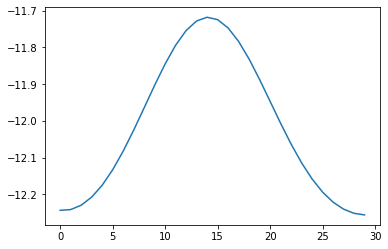

In [ ]:
llm('reac1-state1_simple.xyz', 'reac1-state2_simple.xyz', 'reac01-lmm-teste', n=30)

Como agora estamos a considerar menos átomos, os cálculos são muito mais rápidos... também é possível que precisemos de parametros menos agressivos no cálculo `--path`.

In [ ]:
# calculo path

p1_fn = '/content/work_dir/reac01-lmm-teste-lmm000-guess.xyz'
p2_fn = '/content/work_dir/reac01-lmm-teste-lmm025-guess.xyz'

!rm reac01-path*

# ver https://github.com/grimme-lab/xtb/blob/main/man/xcontrol.7.adoc

with open('xtb-path.conf','w') as f:
  f.write("""

$path
 # number of runs for pathfinder
 nrun = 5
 # number of points on the path to optimize
 #nopt = 20
 npoint = 20
 # number of steps to optimize the points on the path
 anopt = 1
 # factor for RMSD criterium pushing away from the reactant structure
 kpull = -0.1
 # factor for RMSD criterium pulling towards the product structure
 kpush = 0.01
 # width of the RMSD criterium
 alp = 0.001
$end
  """)

run_xtb(f"{p1_fn} --path {p2_fn} --input xtb-path.conf --namespace reac01-path > reac01-path.out")

b''

In [ ]:
! rm reac01-ts-hess*
run_xtb("/content/work_dir/reac01-path.xtbpath_ts.xyz --hess --acc 0.001 --namespace reac01-ts-hess > reac01-ts-hess.out")

b''

In [ ]:
with open('xtb-opt.conf','w') as f:
  f.write("""
$opt
 engine=inertial
 optlevel=-1
 rcut=1.2
 maxdispl=0.00001
 microcycle=1
$end
  """)

run_xtb(f"{p1_fn} --ohess --acc 0.00001 --namespace reac01-reactant-hess  > reac01-reactant-hess.out")
run_xtb(f"{p2_fn} --ohess --acc 0.00001 --namespace reac01-product-hess  > reac01-product-hess.out")

b''

In [ ]:
compile_reaction_data('reac01-reactant-hess.out','reac01-ts-hess.out','reac01-product-hess.out')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactant final geometry


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Animation of the Reaction Coord. at the TS


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactant final geometry
                Energy          Enthalpy       Gibbs Energy  
 Delta (D)             0.00             0.01             0.01
 Eact (D)            155.21           150.25           150.25
 Delta (I)            -0.00            -0.01            -0.01
 Eact (I)            155.20           150.24           150.24
Value of the imaginary frequency at TS:              -100.33


In [ ]:
# No caso anterior, os reagentes "saltam" a barreira e optimizam para os produtos
# neste caso, temos que ir buscar uma estrutura inicial dos reagentes a uma frame anterior.

extract_geo('/content/work_dir/sys03-mtd03.xtb.trj',33,'reac1-reactant-preguess.xyz')
isolate_molecules_with_atoms('reac1-reactant-preguess.xyz',[123-1,125-1],'reac1-reactant-guess.xyz')
! rm reac01-reactant-hess*
run_xtb(f"reac1-reactant-guess.xyz --ohess --acc 0.00001 --namespace reac01-reactant-hess  > reac01-reactant-hess.out")

# e agora sim temos um relatório da reacção elementar
compile_reaction_data('reac01-reactant-hess.out','reac01-ts-hess.out','reac01-product-hess.out')


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactant final geometry


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Animation of the Reaction Coord. at the TS


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactant final geometry
                Energy          Enthalpy       Gibbs Energy  
 Delta (D)          -154.49          -152.02          -132.01
 Eact (D)              0.71            -1.79            -1.79
 Delta (I)           154.49           152.02           132.01
 Eact (I)            155.20           150.24           150.24
Value of the imaginary frequency at TS:              -100.33
